## Librairies + importation

In [60]:
from pathlib import Path
from pyomeca import Analogs
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import pandas as pd
import xarray as xr
import feather
import csv
import re
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain, product, pairwise
from more_itertools import consecutive_groups

import configparser
import tkinter as tk
from tkinter import filedialog

# Data_Path = Path(
#     "C:\\Users\\l.boisson\\Documents\\LPG\\Manips"
# )

sns.set_theme()
sns.set_style("white")

In [61]:
# Create a GUI window
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

## Définition des fonctions

In [62]:
def extract_file_info(file_path):
    match = re.match(r"(\d{3})_([A-Z]+)_([A-Z]+)_([A-Z]+(?:_\d{2,3})?)_(\d{2})", file_path)
    
    if match:
        participant = match.group(1)
        groupe = match.group(2)
        condition = match.group(3)
        contraction = match.group(4)
        essai = match.group(5)
        
        return {
            "participant": participant,
            "groupe": groupe,
            "condition": condition,
            "contraction": contraction,
            "essai": essai
        }
    else:
        return None



## Extraction données data pour calcul montée en force

In [63]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("**/**/**/**/**/**/*.cxp"):
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    
    if file_info is not None:
        contraction_type = file_info["contraction"]
        if contraction_type in ["INV", "EV"]:
            skiprows = 151
        else:
            skiprows = 211
        
        data = pd.read_table(
            file_path,
            on_bad_lines='skip',
            encoding='latin-1',
            skiprows=skiprows,
            names=["Force", "Vitesse", "Angle"],
            header=0
        )
        
        data = data.assign(**file_info)
        
        df_column = pd.concat([df_column, data])

df_column['Frame'] = df_column.groupby(["participant", "groupe", "condition", "contraction", "essai"]).cumcount() + 1

df_column['Time'] = df_column['Frame'] / 256
df_column['Vitesse'] = df_column['Vitesse']
df_column['Angle'] = df_column['Angle']

df_column = df_column.reset_index(drop=True)
# df_column.set_index(["participant", "groupe", "condition", "contraction", "essai", "Frame"], inplace=True)

df_column

,Force,Vitesse,Angle,participant,groupe,condition,contraction,essai,Frame,Time
0,-0.156,15.231,15.187,002,HUB,POST,CON_120,01,1,0.003906
1,-0.095,14.841,15.245,002,HUB,POST,CON_120,01,2,0.007812
2,-0.278,14.841,15.303,002,HUB,POST,CON_120,01,3,0.011719
3,-0.125,15.231,15.362,002,HUB,POST,CON_120,01,4,0.015625
4,-0.125,14.841,15.420,002,HUB,POST,CON_120,01,5,0.019531
...,...,...,...,...,...,...,...,...,...,...
1239344,-0.196,0.391,0.137,032,RC,PRE,INV,02,3948,15.421875
1239345,-0.074,0.000,0.137,032,RC,PRE,INV,02,3949,15.425781
1239346,-0.043,-0.391,0.136,032,RC,PRE,INV,02,3950,15.429688
1239347,-0.104,0.391,0.137,032,RC,PRE,INV,02,3951,15.433594


<AxesSubplot: xlabel='Time', ylabel='Force'>

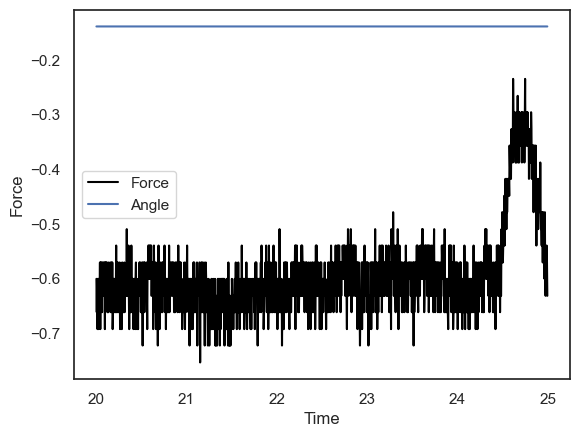

In [64]:
test = df_column[
    (df_column['participant'] == '024') &
    (df_column['condition'] == 'PRE') &
    (df_column['contraction'] == 'EV')
     & (df_column['essai'] == '01')
     & (df_column['Time'] > 20) & (df_column['Time'] < 25)
]

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Force',
    label="Force",
    c = 'black'
    )

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Angle',
    label="Angle"
    )

<AxesSubplot: xlabel='Time', ylabel='Force'>

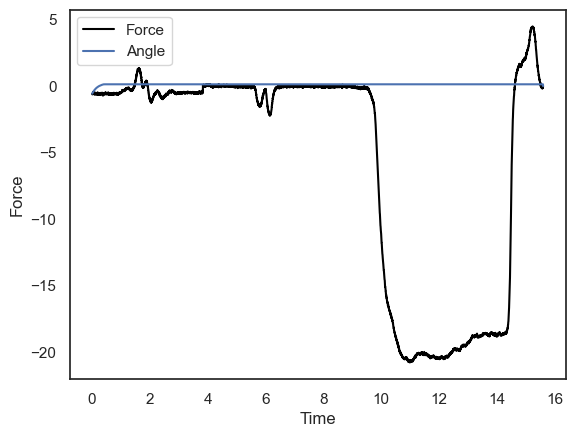

In [65]:
test = df_column[
    (df_column['participant'] == '020') &
    (df_column['condition'] == 'PRE') &
    (df_column['contraction'] == 'EV')
     & (df_column['essai'] == '01')
                        #   & (df_column['Time'] > 2) & (df_column['Time'] < 4)
]

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Force',
    label="Force",
    c = 'black'
    )

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Angle',
    label="Angle"
    )

In [116]:
def filter_signal(df,start_time, end_time = None, additional_conditions=None):
    """
    Filter the signal DataFrame based on specified conditions and time range.

    Parameters:
        df (DataFrame): Input DataFrame containing the signal data.
        participant (str): Participant identifier.
        contraction (str): Contraction identifier.
        condition (str): Condition identifier.
        trial (int): Trial number.
        start_time (float): Start time for the desired signal segment.
        end_time (float): End time for the desired signal segment.
        additional_conditions (dict, optional): Additional filtering conditions as a dictionary.

    Returns:
        DataFrame: Filtered DataFrame containing the desired signal segment.
    """
    # Define base filtering conditions
    base_conditions = (df['Time'] >= start_time)
                      
    # Apply end time condition if provided
    if end_time is not None:
        base_conditions &= (df['Time'] <= end_time)
    
    # Apply additional filtering conditions if provided
    if additional_conditions:
        for key, value in additional_conditions.items():
            base_conditions &= (df[key] == value)

    # Apply filtering and return the result
    filtered_df = df[base_conditions]
    return filtered_df

def zero_mean_first_5sec(df):
    if np.isin(df.contraction.unique(),['EV','INV']):
        mean = df.Force.head(200).mean()
        df.Force = df.Force-mean
        return df
    else:
        return df
    
    
def detection_sens_mouvement(grp):
    print(grp.name)
    test_exception = grp.name
    if grp.contraction.unique() == 'EV':
        grp = grp.assign(mouvement=['Eversion']*len(grp),
                         repetition=1)
        
        return grp
    elif grp.contraction.unique() == 'INV':
        grp = grp.assign(mouvement=['Inversion']*len(grp),
                         repetition=1)
        return grp
    
    data_max_ev = grp[np.isclose(grp['Angle'],grp['Angle'].max(),0.005)]
    data_min_ev = grp[np.isclose(grp['Angle'],grp['Angle'].min(),0.005)]

    start_eversion = []
    start_inversion = []
 
    for group in consecutive_groups(data_max_ev.Frame):
        # print(list(group)[-1])
        start_eversion.append(list(group)[-1])

    for group in consecutive_groups(data_min_ev.Frame):
        # test3 = grp[grp.index > first_value]
        start_inversion.append(list(group)[-1])
    
    angle_change = start_eversion + start_inversion
    if grp.contraction.unique() == 'EXC':
        grp = grp.assign(mouvement=['Inversion']*len(grp))
    else:
        grp = grp.assign(mouvement=['Eversion']*len(grp))
        
    # for a, b in zip(start_eversion,start_inversion):
    #     # print(a)
    #     grp.loc[(grp.Frame > a) & (grp.Frame < b),'mouvement'] = 'Eversion'
    # if grp.name == ():
    grp = grp[(grp.Frame > start_eversion[0]) &
                (grp.Frame < start_eversion[-1])]

    positive = grp.Force.values > 0
    zero_crossing = np.where(np.bitwise_xor(positive[1:],positive[:-1]))[0] + grp.index[0]

    if test_exception == ('009', 'PRE', 'EXC', '02'):
        zero_crossing = np.concatenate([zero_crossing[3:4],zero_crossing[6:]])
    elif test_exception == ('018', 'POST', 'EXC', '01'):
        zero_crossing = np.insert(zero_crossing[4:],0,zero_crossing[1])    
    elif test_exception == ('011', 'POST', 'EXC', '01'):
        zero_crossing = zero_crossing[4:]    

        
    tolerance = 150
    filtered_zero_crossing = []
    angle_change.sort()
    for point in angle_change:
        test2 = zero_crossing[np.isclose(point,grp[grp.index.isin(zero_crossing)].Frame, atol = tolerance)]
        if len(test2) > 1:
            test2 = [min(test2)]
        if len(test2) != 0:
            filtered_zero_crossing.extend(test2)
    # filtered_zero_crossing = []
    # filtered_zero_crossing = [point for point in zero_crossing if any(np.isclose(grp[grp.index == point].Frame, angle_change, atol=tolerance))]
    # for point in zero_crossing:
    #     if any(np.isclose(grp[grp.index == point].Frame, angle_change, atol=tolerance)):
    #         if np.isclose(grp[grp.index == point].Frame, angle_change, atol=tolerance).sum() == 1:
    #             filtered_zero_crossing.append(point)
    #         else:
    #             # Find the closest angle_change for the current zero_crossing point
    #             closest_angle_change = min(angle_change, key=lambda ac: abs(grp[grp.index == point].Frame - ac))
    #             filtered_zero_crossing.append((closest_angle_change))
        
    if test_exception == ('028', 'POST', 'EXC', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('008', 'POST', 'CON_60', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('007', 'POST', 'EXC', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('009', 'POST', 'EXC', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('009', 'POST', 'EXC', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('009', 'PRE', 'EXC', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('004', 'PRE', 'EXC', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]        
    elif test_exception == ('020', 'PRE', 'EXC', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]        
    elif test_exception == ('024', 'PRE', 'EXC', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:]                                          
    elif test_exception == ('011', 'POST', 'CON_60', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('011', 'POST', 'CON_60', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('032', 'POST', 'CON_60', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('028', 'POST', 'CON_60', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]        
    elif test_exception == ('032', 'PRE', 'CON_120', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:] 
    elif test_exception == ('002', 'PRE', 'CON_120', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]        
    elif test_exception == ('004', 'PRE', 'CON_120', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
    elif test_exception == ('028', 'POST', 'CON_120', '01'):
        filtered_zero_crossing = filtered_zero_crossing[1:]        
    elif test_exception == ('028', 'POST', 'CON_120', '02'):
        filtered_zero_crossing = filtered_zero_crossing[1:]
        
                                                               
    if len(filtered_zero_crossing) > 7:
        filtered_zero_crossing = filtered_zero_crossing[:7]
                            
    grp = grp[(grp.index > filtered_zero_crossing[0]) &
                (grp.index < filtered_zero_crossing[-1])]
          
    if grp.contraction.unique() == 'EXC':
        current_state = 'Inversion'
        nrep = 1
        # Iterate over pairs
        for start, end in pairwise(filtered_zero_crossing):
            grp.loc[(grp.index >= start) & (grp.index <= end), 'mouvement'] = current_state
            grp.loc[(grp.index >= start) & (grp.index <= end), 'repetition'] = nrep
            # Switch between 'Eversion' and 'Inversion'
            current_state = 'Eversion' if current_state == 'Inversion' else 'Inversion'
            if current_state == 'Inversion':
                nrep += 1
    else:
        # Initialize the state variable
        current_state = 'Eversion'
        nrep = 1
        # Iterate over pairs
        for start, end in pairwise(filtered_zero_crossing):
            grp.loc[(grp.index >= start) & (grp.index <= end), 'mouvement'] = current_state
            grp.loc[(grp.index >= start) & (grp.index <= end), 'repetition'] = nrep
            # Switch between 'Eversion' and 'Inversion'
            current_state = 'Inversion' if current_state == 'Eversion' else 'Eversion'
            if current_state == 'Eversion':
                nrep += 1        
    return grp

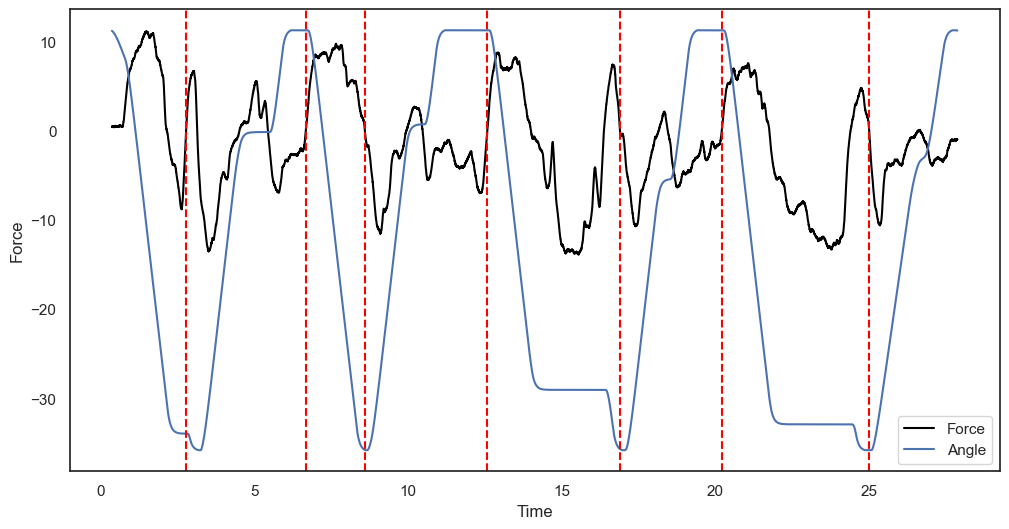

In [117]:
test = df_column[
    (df_column['participant'] == '004') &
    (df_column['condition'] == 'PRE') &
    (df_column['contraction'] == 'EXC')
     & (df_column['essai'] == '01')
                        #   (df_emg_rms['Time'] > 4) & (df_emg_rms['Time'] < 12) & 
]

data_max_ev = test[np.isclose(test['Angle'],test['Angle'].max(),0.005)]
data_min_ev = test[np.isclose(test['Angle'],test['Angle'].min(),0.005)]

start_eversion = []
start_inversion = []

for group in consecutive_groups(data_max_ev.Frame):
    # print(list(group)[-1])
    start_eversion.append(list(group)[-1])

for group in consecutive_groups(data_min_ev.Frame):
    # test3 = test[test.index > first_value]
    start_inversion.append(list(group)[-1])
    
test = test.assign(mouvement=['Inversion']*len(test))
# for a, b in zip(start_eversion,start_inversion):
#     # print(a)
#     test.loc[(test.Frame > a) & (test.Frame < b),'mouvement'] = 'Eversion'
test = test[(test.Frame > start_eversion[0]) &
            (test.Frame < start_eversion[-1])]

positive = test.Force.values > 0
zero_crossing = np.where(np.bitwise_xor(positive[1:],positive[:-1]))[0] + test.index[0]
angle_change = start_eversion + start_inversion
tolerance = 150
filtered_zero_crossing = []
angle_change.sort()
# zero_crossing = zero_crossing[4:]
for point in angle_change:
    test2 = zero_crossing[np.isclose(point,test[test.index.isin(zero_crossing)].Frame, atol = tolerance)]
    if len(test2) > 1:
        test2 = [min(test2)]
    if len(test2) != 0:
        filtered_zero_crossing.extend(test2)
        
# test = test[(test.index > zero_crossing[0]) &
#             (test.index < zero_crossing[-2])]
# current_state = 'Eversion'
# zero_crossing = np.concatenate([zero_crossing[0],zero_crossing[3:]])    

# # Iterate over pairs
# for start, end in pairwise(zero_crossing):
#     test.loc[(test.index >= start) & (test.index <= end), 'mouvement'] = current_state
    
#     # Switch between 'Eversion' and 'Inversion'
#     current_state = 'Inversion' if current_state == 'Eversion' else 'Eversion'
# data_plot = test[(test['Time'] > 0) & (test['Time'] < 60)].set_index('Time')
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Force',
    label="Force",
    c = 'black'
    )

sns.lineplot(
    data=test,
    x = 'Time',
    y = 'Angle',
    label="Angle"
    )

for timestamp in filtered_zero_crossing:
    ax.axvline(x=test.loc[timestamp,'Time'], color='red', linestyle='dashed')    

### Découpâge tache iso

In [118]:
df_column[df_column.contraction.isin(['INV','EV'])] = df_column[(df_column.Time > 4.2) & (df_column.contraction.isin(['INV','EV']))]

In [119]:
df_column = df_column.groupby(['participant','groupe','condition','contraction','essai'], group_keys = False).apply(zero_mean_first_5sec)

In [120]:

recordings = {
    ('018', 'INV', 'PRE', '02'): {'start_time': 9, 'end_time': None},
    ('002', 'INV', 'PRE', '01'): {'start_time': 4.5, 'end_time': None},
    ('018', 'EV', 'PRE', '01'): {'start_time': 0, 'end_time': 20},
    ('011', 'EV', 'PRE', '02'): {'start_time': 8, 'end_time': None},
    ('028', 'CON_60', 'PRE', '01'): {'start_time': 1, 'end_time': None},
    ('020', 'EV', 'PRE', '01'): {'start_time': 8, 'end_time': None},
    ('024', 'EV', 'PRE', '01'): {'start_time': 0, 'end_time': 20},
    # ('032', 'CON_60', 'PRE', '01'): {'start_time': 1, 'end_time': None},
    # ('011', 'CON_60', 'POST', '02'): {'start_time': 3, 'end_time': None},
    # ('008', 'CON_60', 'POST', '01'): {'start_time': 1, 'end_time': None},
    # ('002', 'CON_120', 'PRE', '02'): {'start_time': 3, 'end_time': None},
    # ('028', 'EXC', 'POST', '02'): {'start_time': 1, 'end_time': None},
    # ('009', 'EXC', 'PRE', '02'): {'start_time': 2.5, 'end_time': None},

    # ('032', 'CON_120', 'PRE', '01'): {'start_time': 2.3, 'end_time': None},
    # Add more recordings as needed
}

for key, params in recordings.items():
    participant_id, contraction_id, condition_id, trial_number = key
    mask = (df_column['participant'] == participant_id) & \
                (df_column['contraction'] == contraction_id) & \
                (df_column['condition'] == condition_id) & \
                (df_column['essai'] == trial_number)
    df_column[mask] = filter_signal(df_column[mask], 
                                  params['start_time'], params['end_time'], params.get('additional_conditions'))
    # Process filtered_data as needed



In [121]:
df_force_phase = df_column.groupby(['participant','condition','contraction','essai'], group_keys=False).apply(detection_sens_mouvement)

('002', 'POST', 'CON_120', '01')
('002', 'POST', 'CON_120', '02')
('002', 'POST', 'CON_60', '01')
('002', 'POST', 'CON_60', '02')
('002', 'POST', 'EV', '01')
('002', 'POST', 'EV', '02')
('002', 'POST', 'EXC', '01')
('002', 'POST', 'EXC', '02')
('002', 'POST', 'INV', '01')
('002', 'POST', 'INV', '02')
('002', 'PRE', 'CON_120', '01')
('002', 'PRE', 'CON_120', '02')
('002', 'PRE', 'CON_60', '01')
('002', 'PRE', 'CON_60', '02')
('002', 'PRE', 'EV', '01')
('002', 'PRE', 'EV', '02')
('002', 'PRE', 'EXC', '01')
('002', 'PRE', 'EXC', '02')
('002', 'PRE', 'INV', '01')
('002', 'PRE', 'INV', '02')
('003', 'POST', 'CON_120', '01')
('003', 'POST', 'CON_120', '02')
('003', 'POST', 'CON_60', '01')
('003', 'POST', 'CON_60', '02')
('003', 'POST', 'EV', '01')
('003', 'POST', 'EV', '02')
('003', 'POST', 'EXC', '01')
('003', 'POST', 'EXC', '02')
('003', 'POST', 'INV', '01')
('003', 'POST', 'INV', '02')
('003', 'PRE', 'CON_120', '01')
('003', 'PRE', 'CON_120', '02')
('003', 'PRE', 'CON_60', '01')
('003', '

In [122]:

recordings = {
    ('032', 'CON_120', 'PRE', '01'): {'start_time': 2.315, 'end_time': None},
    # Add more recordings as needed
}

for key, params in recordings.items():
    participant_id, contraction_id, condition_id, trial_number = key
    mask = (df_force_phase['participant'] == participant_id) & \
                (df_force_phase['contraction'] == contraction_id) & \
                (df_force_phase['condition'] == condition_id) & \
                (df_force_phase['essai'] == trial_number)
    df_force_phase[mask] = filter_signal(df_force_phase[mask], 
                                  params['start_time'], params['end_time'], params.get('additional_conditions'))


## Calcul Maximal Rate of Force Development

Maximal rate of force development was equal to the highest RFD during 20-millisecond sampling window (23). Maximal rate of force development was expressed in Newton per second and in relative units, i.e., as a percentage of MVF per second 

=> DIURNAL RHYTHM OF MUSCULAR STRENGTH DEPENDS ON TEMPORAL SPECIFICITY OF SELF-RESISTANCE TRAINING
SANA ZBIDI, BADRANE ZINOUBI, HENRY VANDEWALLE, AND TARAK DRISS
Research Center on Sport and Movement (CeRSM, EA 2931), Sciences and Techniques of the Physical and Sporting Activities


The MRFD was equal to the steepest slope calculated for a 20 ms interval. The value of MRFD was expressed in newtons per second and in relative units, ie as a percentage of MVFmax per second

=> MAXIMAL VOLUNTARY FORCE AND RATE OF FORCE DEVELOPMENT IN HUMANS - IMPORTANCE OF INSTRUCTION
R. SAHALY, H. VANDEWALLE, T. DRISS, H. MONOD


Motor units were recruited over an interval starting from contraction onset (range: 22–233 ms).

=> https://journals.physiology.org/doi/full/10.1152/jn.00330.2019

Once contraction onset has been defined, a number of different measures can be obtained from the rising force–time curve. Some of the more common include force at specific time points (Rousanoglou et al. 2010; Tillin et al. 2010) (Fig. 8a) as well as RFD and impulse, which can both be measured over either overlapping periods starting from 0, e.g., RFD/impulse from 0 to 100 ms relative to onset (Aagaard et al. 2002b; Barry et al. 2005) (Fig. 8a), or consecutive periods, e.g., RFD/impulse from 50 to 100 ms Fig. 7 An unfiltered force–time curve recorded during an explosive contraction of the knee extensors (force is expressed relative to maximal voluntary force). Force onset (0 ms) was detected manually/visually using the systematic method detailed in Tillin et al. (2010). Some automated systems for detecting contraction onset have used arbitrary thresholds between 2 and 3.6 % maximal voluntary force which in this example occurs 24–30 ms after manually detected onset. Figure reproduced with permission from Tillin et al. (2013b) Fig. 8 Common measurements of the rising force–time curve. a Force at specific time points (F50, F100, etc.) and overlapping RFD measurements all starting from force onset (RFD0–50, RFD0–100, etc.). b An identical force trace showing measurements of sequential RFD and sequential impulse both assessed over consecutive periods Eur J Appl Physiol (2016) 116:1091–1116 1109 1 3 relative to onset (Folland et al. 2014; Penailillo et al. 2015) (Fig. 8b). Irrespective of the measure, in all cases multiple time points/periods clearly provide a more comprehensive description of the whole rising curve than single measures. In addition, all measures should be corrected for the gravitational force on the limb.

=> Rate of force development: physiological and methodological considerations

 The time to reach the maximum moment ranged from 629 to 659 ms with no signifi cant joint angle eff ect (p > 0. 05). A significant interaction between contraction time and joint angle (p < 0.05) was found for moment ( ●▶ Fig. 2 ). Specifi cally, at contraction times of 30 and 50 ms, the moment was higher near full knee extension, whereas for times ≥ 150 ms, the moment was higher near full knee fl exion ( ●▶ Fig. 2 ). The optimal knee angle obtained for the maximum moment – angle relation was at 61 ° of knee fl exion, whereas the optimal knee angle obtained for the moment-angle relations during the initial time course of the contraction was shifted to more extended knee positions ( ●▶ Fig. 2 ).

=> https://pubmed.ncbi.nlm.nih.gov/20617488/

The athletes were 28% stronger, and their absolute RFD in the first 50 ms was twofold that of controls. Athletes had greater normalized RFD (4.86 ± 1.46 vs 2.81 ± 1.20 MVC·s(-1)) and neural activation (mean quadriceps, 0.26 ± 0.07 vs 0.15 ± 0.06 Mmax) during the first 50 ms of explosive voluntary contractions. 

=> https://pubmed.ncbi.nlm.nih.gov/19952835/

In [123]:
def reset_time(df):
    print(df.name)
    if df.contraction.unique() == 'INV' :
        df = df[df.Force > 1.5]
    elif df.contraction.unique() == 'EV': 
        df = df[df.Force < -1.5]
    df.Time -= df.Time.values[0]
    return df
df_force_phase = df_force_phase.groupby(['participant','condition','contraction','essai','repetition'], group_keys=False).apply(reset_time)

('002', 'POST', 'CON_120', '01', 1.0)
('002', 'POST', 'CON_120', '01', 2.0)
('002', 'POST', 'CON_120', '01', 3.0)
('002', 'POST', 'CON_120', '02', 1.0)
('002', 'POST', 'CON_120', '02', 2.0)
('002', 'POST', 'CON_120', '02', 3.0)
('002', 'POST', 'CON_60', '01', 1.0)
('002', 'POST', 'CON_60', '01', 2.0)
('002', 'POST', 'CON_60', '01', 3.0)
('002', 'POST', 'CON_60', '02', 1.0)
('002', 'POST', 'CON_60', '02', 2.0)
('002', 'POST', 'CON_60', '02', 3.0)
('002', 'POST', 'EV', '01', 1.0)
('002', 'POST', 'EV', '02', 1.0)
('002', 'POST', 'EXC', '01', 1.0)
('002', 'POST', 'EXC', '01', 2.0)
('002', 'POST', 'EXC', '01', 3.0)
('002', 'POST', 'EXC', '02', 1.0)
('002', 'POST', 'EXC', '02', 2.0)
('002', 'POST', 'EXC', '02', 3.0)
('002', 'POST', 'INV', '01', 1.0)
('002', 'POST', 'INV', '02', 1.0)
('002', 'PRE', 'CON_120', '01', 1.0)
('002', 'PRE', 'CON_120', '01', 2.0)
('002', 'PRE', 'CON_120', '01', 3.0)
('002', 'PRE', 'CON_120', '02', 1.0)
('002', 'PRE', 'CON_120', '02', 2.0)
('002', 'PRE', 'CON_120', '

## Suppression rep raté : 


In [124]:
def drop_data(df, filter_conditions):
    mask = pd.Series([True] * len(df), index=df.index)
    for key, value in filter_conditions.items():
        mask &= (df[key] == value)
    return df[~mask]

# List of dictionaries of filter conditions
filter_conditions_list = [
    {'participant': '018', 'condition': 'PRE', 'contraction': 'EXC', 'essai': '01', 'repetition': 3},
    {'participant': '019', 'condition': 'POST', 'contraction': 'EXC', 'essai': '01', 'repetition': 1},
    {'participant': '004', 'condition': 'POST', 'contraction': 'EXC', 'essai': '01', 'repetition': 1},
    {'participant': '004', 'condition': 'POST', 'contraction': 'EXC', 'essai': '02', 'repetition': 2},
    {'participant': '011', 'condition': 'POST', 'contraction': 'EXC', 'essai': '02', 'repetition': 2},
    {'participant': '032', 'condition': 'PRE', 'contraction': 'EXC', 'essai': '01', 'repetition': 2},
    {'participant': '002', 'condition': 'PRE', 'contraction': 'EXC', 'essai': '01', 'repetition': 2},
    {'participant': '011', 'condition': 'PRE', 'contraction': 'EXC', 'essai': '01', 'repetition': 3},
    {'participant': '020', 'condition': 'PRE', 'contraction': 'EXC', 'essai': '02', 'repetition': 1},
    {'participant': '028', 'condition': 'PRE', 'contraction': 'EXC', 'essai': '02', 'repetition': 1},
    {'participant': '003', 'condition': 'POST', 'contraction': 'EXC', 'essai': '02', 'repetition': 2},
    {'participant': '007', 'condition': 'PRE', 'contraction': 'CON_60', 'essai': '01', 'repetition': 1},
    {'participant': '011', 'condition': 'PRE', 'contraction': 'CON_60', 'essai': '01', 'repetition': 2},
    {'participant': '007', 'condition': 'POST', 'contraction': 'CON_60', 'essai': '01', 'repetition': 1},
]

# Drop data based on filter conditions
for filter_conditions in filter_conditions_list:
    df_force_phase = drop_data(df_force_phase, filter_conditions)



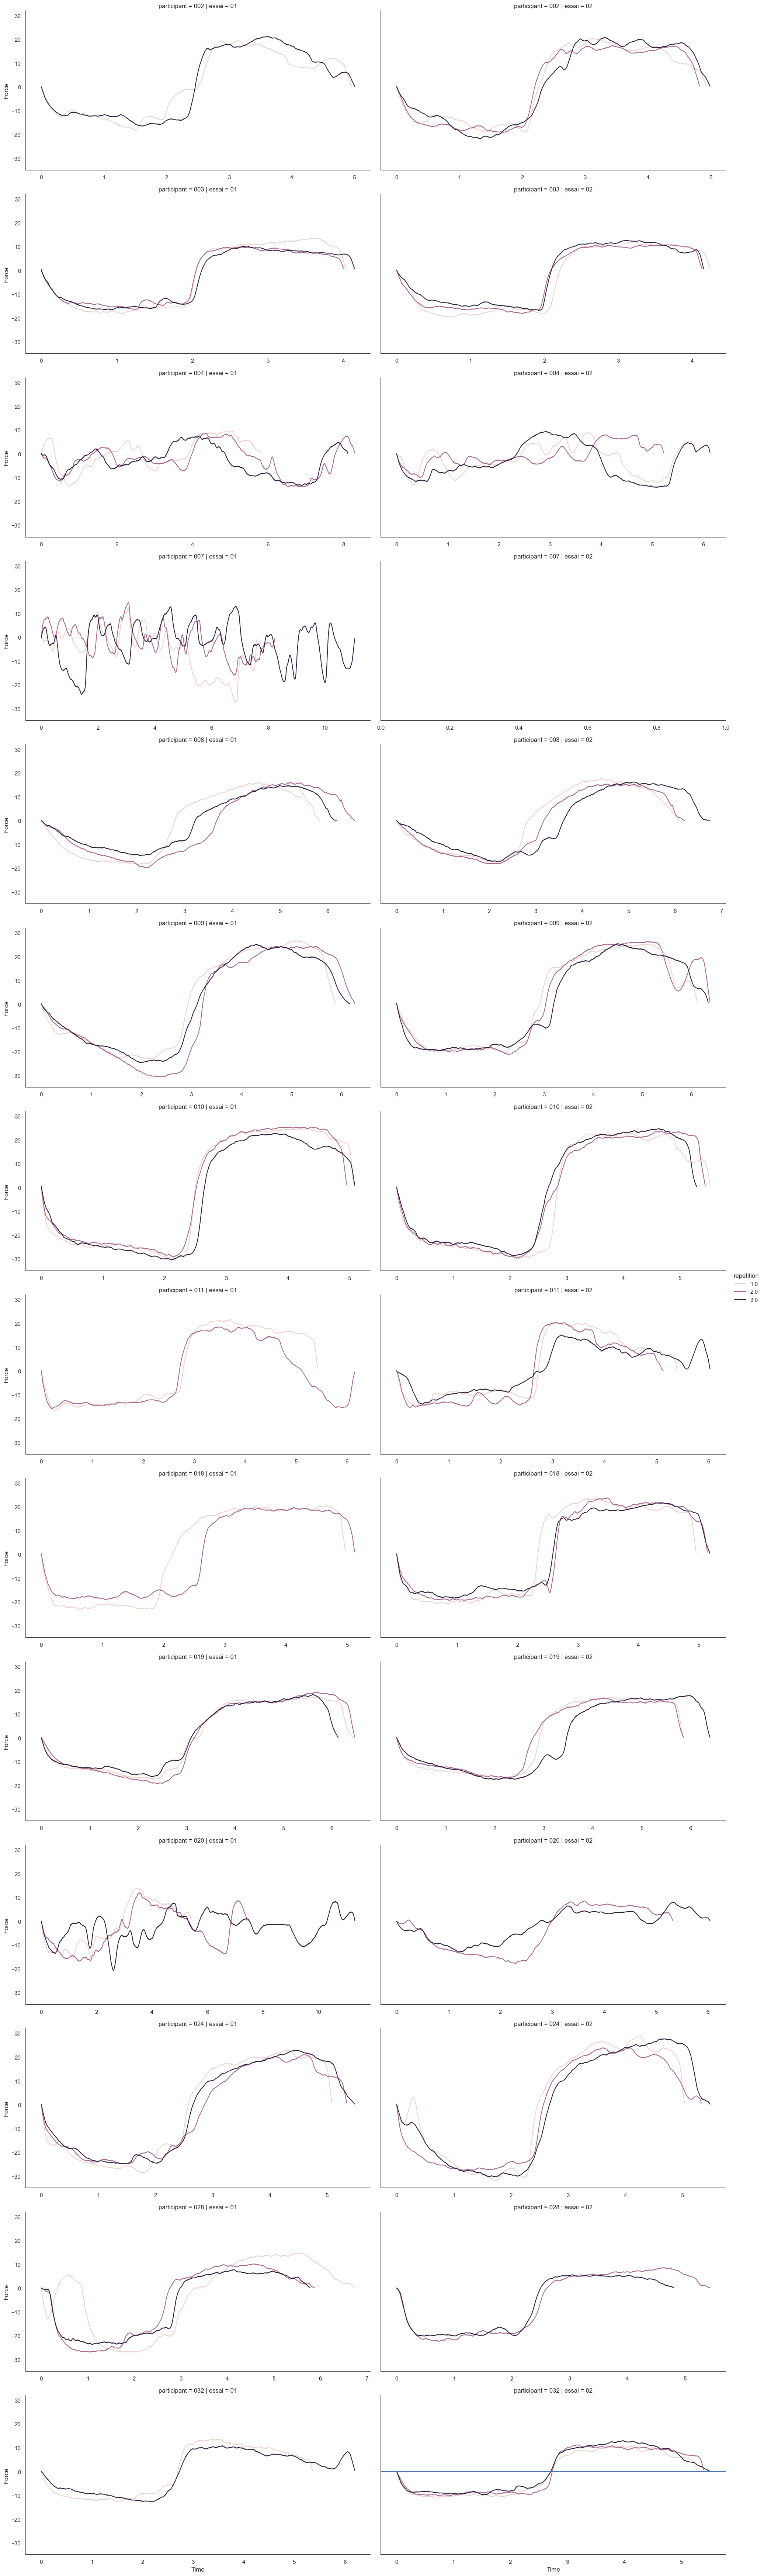

In [125]:
data_plot = df_force_phase[
    # (df_force_phase['participant'] == '009') &
    (df_force_phase['condition'] == 'PRE') &
    (df_force_phase['contraction'] == 'EXC') 
    # & (df_force_phase.Force > 1.5)
    # & (df_force_phase['Time'] > 2) & (df_force_phase['Time'] < 2.4)
]



sns.relplot(data_plot, 
            x= 'Time',
             y = 'Force',
             hue= 'repetition',
             kind = 'line', 
             aspect= 2,
             row = 'participant',
             col = 'essai',
             facet_kws=dict(sharex=False)
             )

plt.axhline(0)
# plt.axvline(4.5)

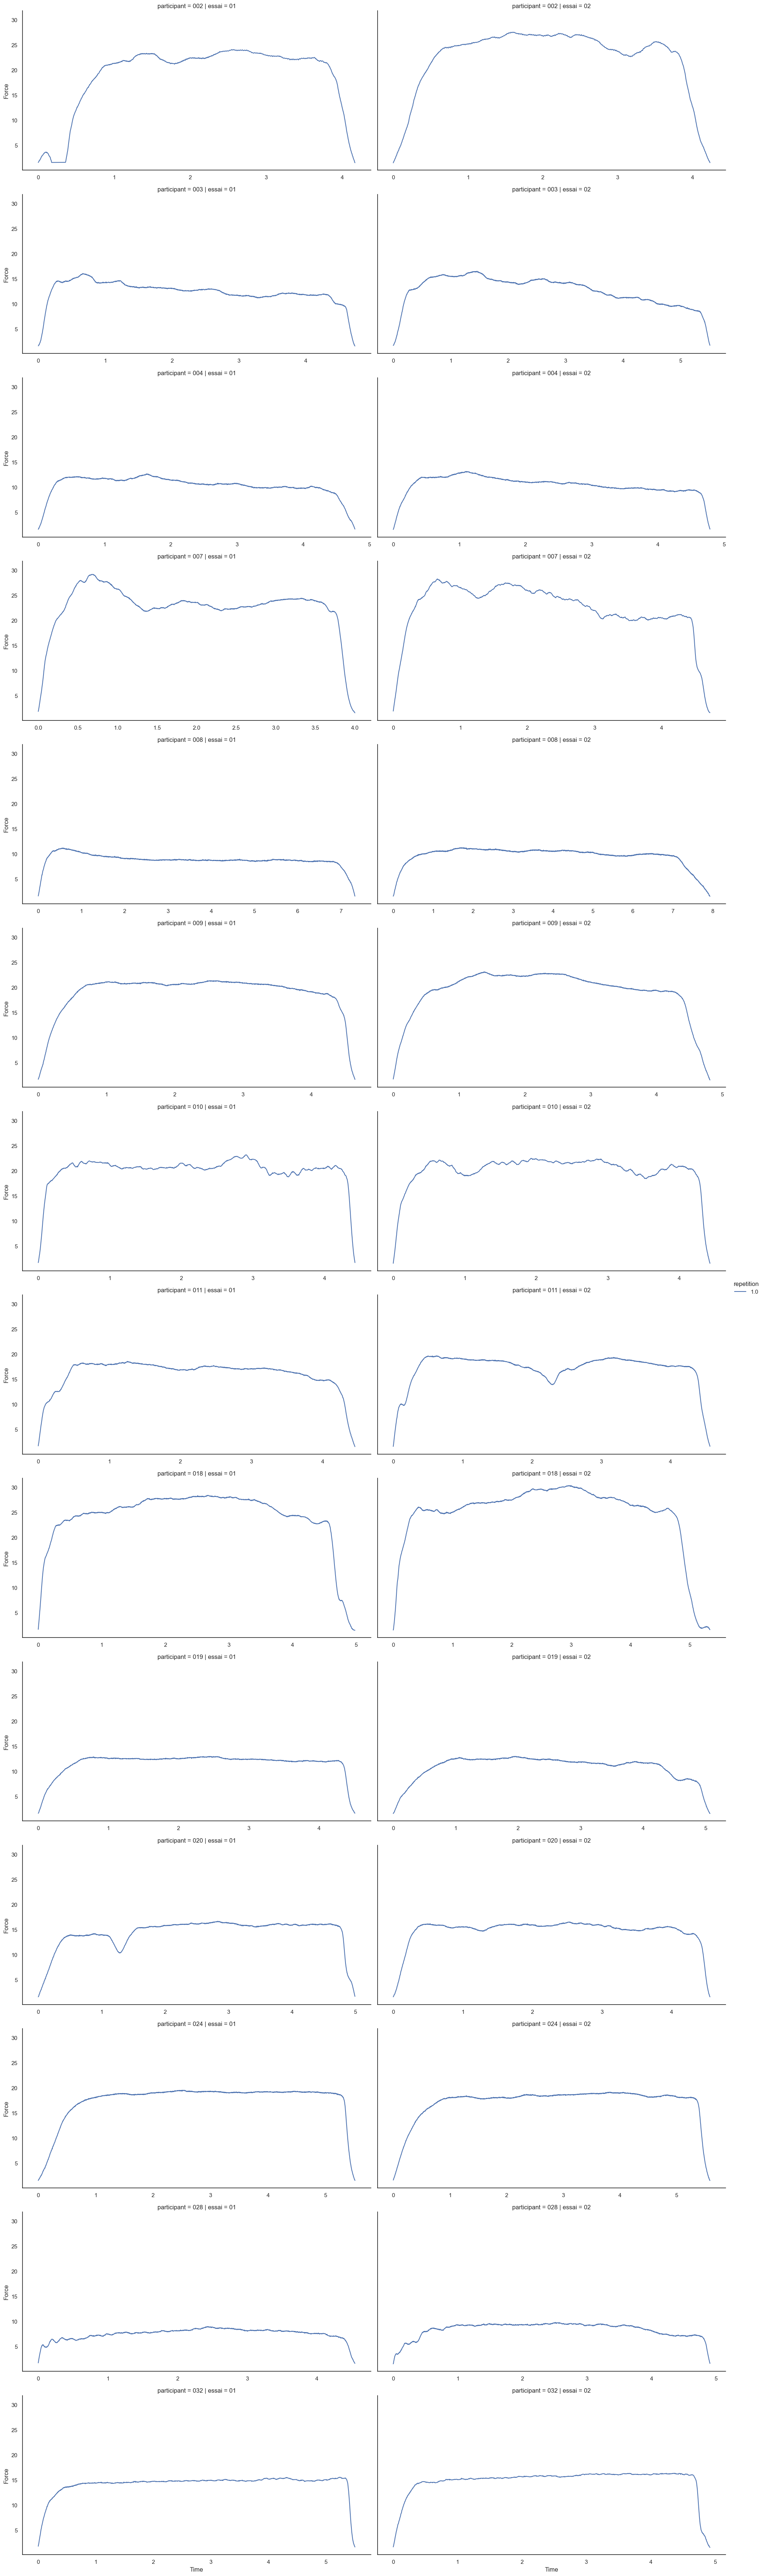

In [126]:
data_plot = df_force_phase[
    # (df_force_phase['participant'] == '009') &
    (df_force_phase['condition'] == 'POST') &
    (df_force_phase['contraction'] == 'INV') 
    # & (df_force_phase.Force > 1.5)
                        #   (df_emg_rms['Time'] > 4) & (df_emg_rms['Time'] < 12) & 
]

sns.relplot(data_plot, 
            x= 'Time',
             y = 'Force',
             hue= 'repetition',
             kind = 'line', 
             aspect= 2,
             row = 'participant',
             col = 'essai',
             facet_kws=dict(sharex=False)
             )

# plt.axhline(1.5)
# plt.axvline(4.5)

In [127]:
rfd_test = df_force_phase[
    (df_force_phase['participant'] == '024') &
    (df_force_phase['condition'] == 'PRE') &
    (df_force_phase['contraction'] == 'INV')
     & (df_force_phase['essai'] == '02')
                        #   (df_emg_rms['Time'] > 4) & (df_emg_rms['Time'] < 12) & 
]

def calc_slope(df, time_col = 'Time', var_col = 'Force'):
    dv = df[var_col].values[-1] - df[var_col].values[0]
    dt = df[time_col].values[-1] - df[time_col].values[0]
    return dv/dt
    
    
# 100 * 256/1000
frame_zero = rfd_test.Frame.values[0]
t50 = frame_zero + round((256*50)/1000)
t100 = frame_zero + round((256*100)/1000)
t150 = frame_zero + round((256*150)/1000)
rfd_test[rfd_test.Frame == t50]
rfd_test.rolling(13).apply(lambda x: calc_slope(x))

KeyError: 'Force'

In [ ]:
calc_slope(rfd_test[26:39])

# rfd_test[:13]

30.591999999999995

In [ ]:
(rfd_test.Force.diff(12)/rfd_test.Time.diff(12))[12::13]

1049608    13.034667
1049621    20.842667
1049634    30.592000
1049647    35.157333
1049660    40.362667
             ...    
1050713   -41.024000
1050726   -99.605333
1050739   -65.088000
1050752   -34.496000
1050765   -23.445333
Length: 90, dtype: float64

In [ ]:
def compute_rfd(df):

frequency = 256

df_column['Diff_force'] = abs(df_column\
    .groupby([
        "participant", 
        "groupe", 
        "condition", 
        "contraction", 
        "essai"
        ])['Force'].diff())

df_column['MRFD'] = df_column['Diff_force'] / (1 / frequency * 20 / 1000)

df_column

,Force,Vitesse,Angle,participant,groupe,condition,contraction,essai,Frame,Time,Force_abs,Diff_force,MRFD
0,-0.15600,15.231,15.187,002,HUB,POST,CON_120,01,1.0,0.003906,0.156,NaN,NaN
1,-0.09500,14.841,15.245,002,HUB,POST,CON_120,01,2.0,0.007812,0.095,0.061,780.8
2,-0.27800,14.841,15.303,002,HUB,POST,CON_120,01,3.0,0.011719,0.278,0.183,2342.4
3,-0.12500,15.231,15.362,002,HUB,POST,CON_120,01,4.0,0.015625,0.125,0.153,1958.4
4,-0.12500,14.841,15.420,002,HUB,POST,CON_120,01,5.0,0.019531,0.125,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148025,-0.30149,0.391,0.137,032,RC,PRE,INV,02,3948.0,15.421875,0.196,0.153,1958.4
1148026,-0.17949,0.000,0.137,032,RC,PRE,INV,02,3949.0,15.425781,0.074,0.122,1561.6
1148027,-0.14849,-0.391,0.136,032,RC,PRE,INV,02,3950.0,15.429688,0.043,0.031,396.8
1148028,-0.20949,0.391,0.137,032,RC,PRE,INV,02,3951.0,15.433594,0.104,0.061,780.8


## MRFD par participant, groupe, condition, contraction, essai

In [ ]:
max_MRFD = df_column.groupby([
    'participant',
    'groupe',
    'condition',
    'contraction',
    'essai'
    ])['MRFD'].max()

max_MRFD_df = max_MRFD.reset_index()

max_MRFD_df

,participant,groupe,condition,contraction,essai,MRFD
0,002,HUB,POST,CON_120,01,12121.6
1,002,HUB,POST,CON_120,02,11596.8
2,002,HUB,POST,CON_60,01,12889.6
3,002,HUB,POST,CON_60,02,10944.0
4,002,HUB,POST,EV,01,9766.4
...,...,...,...,...,...,...
254,032,RC,PRE,EV,02,4684.8
255,032,RC,PRE,EXC,01,7808.0
256,032,RC,PRE,EXC,02,6246.4
257,032,RC,PRE,INV,01,10547.2
